## 데이터 수집
- 파이썬으로 해도 좋지만, 빠르게 진행하기 위해서 구글 개발자 도구에서 진행
- [https://play.google.com/store/apps/details?id=com.rainist.banksalad2&showAllReviews=true](https://play.google.com/store/apps/details?id=com.rainist.banksalad2&showAllReviews=true) 로 들어간 후, 콘솔에서 아래 명령어 입력
    - 유용한 리뷰 순서라 최근 리뷰 중 누락이 존재할 수 있음
    - 총 1,400개의 리뷰를 수집 (안드로이드)

```
var reviews = document.querySelectorAll('div[class="d15Mdf bAhLNe"]')

var data = []
reviews.forEach(v => data.push({body: v.outerHTML}))
```
- 별점이랑 이름, 리뷰 등을 따로 가져올 순 있지만 한방에 HTML로 가져와서 파이썬에서 전처리
- list를 콘솔에서 입력하고, 우측 마우스 클릭 후 Store as global variable 클릭
- ```copy(temp1)```을 하면 클립보드로 데이터가 들어감
- ```review-data.json```으로 저장

In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import json
import re
from bs4 import BeautifulSoup
import warnings
from konlpy.tag import Twitter
from sklearn.feature_extraction.text import CountVectorizer

warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_json("review-data.json")

In [3]:
df.head(2)

,body
0,"<div class=""d15Mdf bAhLNe""><div class=""xKpxId ..."
1,"<div class=""d15Mdf bAhLNe""><div class=""xKpxId ..."


In [4]:
p = re.compile(r'\d+')
def parser(body):
    bs = BeautifulSoup(body, 'html.parser')
    user_name = bs.find('span', class_='X43Kjb').text
    date = bs.find('span', class_='p2TkOb').text
    rating = bs.find('div', {'role':'img'})['aria-label']
    rating = p.findall(rating)[-1]
    review_text = bs.find('span', {'jsname':'bN97Pc'}).text
    return user_name, date, rating, review_text

In [5]:
%%time
df['user_name'], df['date'], df['rating'], df['review_text'] = zip(*df['body'].map(parser))

CPU times: user 4.28 s, sys: 17 ms, total: 4.3 s
Wall time: 4.31 s


In [6]:
del df["body"]

In [7]:
df['date'] = pd.to_datetime(df['date'], format='%Y년 %m월 %d일')

In [8]:
df.head(2)

,user_name,date,rating,review_text
0,Google 사용자,2018-08-19,5,정말 좋아요!! 몇개월 째 잘쓰고있어요ㅎㅎ 한가지 저한테만! 아쉬운 점은 예산 계획...
1,Google 사용자,2018-08-19,2,첨엔 좋았는데 쓰다보면 자주 은행 연동 끊기고 오류 나는 거 계속 반복되고 고객센터...


In [9]:
df = df.sort_values(by='date', ascending=False).reindex()   

In [10]:
print("최소 :", min(df['date'].value_counts().index))
print("최대 :", max(df['date'].value_counts().index))

최소 : 2017-12-21 00:00:00
최대 : 2018-08-19 00:00:00


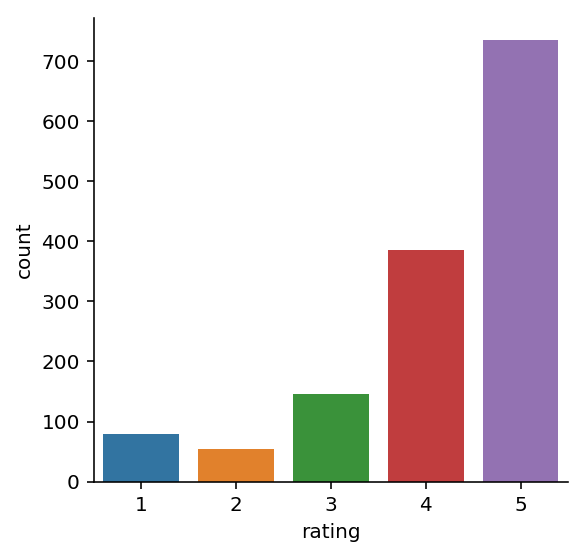

In [11]:
sns.factorplot('rating',kind='count',data=df)

In [12]:
df['rating'].value_counts()

5    735
4    385
3    146
1     80
2     54
Name: rating, dtype: int64

- 17년 12월 21일 ~ 18년 8월 19일의 리뷰 평가는 매우 좋음 
- 5점이 압도적으로 많음
- 3점 이하 평점을 준 유저들의 리뷰를 보자

In [13]:
low_rate_review = df[df['rating'] <= '3']['review_text']

In [14]:
len(low_rate_review)

280

In [15]:
low_rate_review[:10]

1     첨엔 좋았는데 쓰다보면 자주 은행 연동 끊기고 오류 나는 거 계속 반복되고 고객센터...
78                                     들어가자 마자 오류떠서 안떠요
73                 벌써 3번이나 지문인식이 안먹히네요 인식해도 비밀번호 다시쳐야하고
19    은행 추가해서 관리하다가 카드 추가하면 기존 데이터 다 초기화됩니다. 문의 넣으면 ...
20    신용카드 미분류가 너무 많음. 미분류 건 업체별로 한번 업종 선택하면 다음것도 알아...
80                               현대차증권도 추가해 주시면 고맙겠습니다.
66                                     카뱅은 왜 연동이 안될까요..
72                            증권사 이베스트증권 연동 시도시 앱 다운되네요
67                 잘 사용하고있었는데 휴대폰초기화후 재설치했더니 연동오류가자주납니다
34               카카오뱅크는... 추가 안되나요? 카카오뱅크만 써서.......ㅠㅠㅠ
Name: review_text, dtype: object

- 전처리 : 글자만 남기고 제거

In [19]:
low_rate_review = low_rate_review.apply(lambda x:re.sub('[^가-힣\s\d]',"",x))

In [20]:
low_rate_review[:10]

1     첨엔 좋았는데 쓰다보면 자주 은행 연동 끊기고 오류 나는 거 계속 반복되고 고객센터...
78                                     들어가자 마자 오류떠서 안떠요
73                  벌써 번이나 지문인식이 안먹히네요 인식해도 비밀번호 다시쳐야하고
19    은행 추가해서 관리하다가 카드 추가하면 기존 데이터 다 초기화됩니다 문의 넣으면 친...
20    신용카드 미분류가 너무 많음 미분류 건 업체별로 한번 업종 선택하면 다음것도 알아서...
80                                현대차증권도 추가해 주시면 고맙겠습니다
66                                       카뱅은 왜 연동이 안될까요
72                            증권사 이베스트증권 연동 시도시 앱 다운되네요
67                 잘 사용하고있었는데 휴대폰초기화후 재설치했더니 연동오류가자주납니다
34                             카카오뱅크는 추가 안되나요 카카오뱅크만 써서
Name: review_text, dtype: object

### 자연어 처리
- 단어 word count 정도만 체크
- 리뷰라 없을 것 같지만 1단어만 작성한 것은 제외

In [21]:
tagger = Twitter()

In [23]:
def get_word(sentence):
    nouns = tagger.nouns(sentence)
    return [noun for noun in nouns if len(noun) > 1] 

In [24]:
cv = CountVectorizer(tokenizer=get_word, max_features=300)
tdf = cv.fit_transform(low_rate_review)
words = cv.get_feature_names()

In [26]:
words[:5]

['가계부', '가나', '가요', '가입', '가장']

In [27]:
count_mat = tdf.sum(axis=0)
count_mat

matrix([[ 16,   1,  16,  11,   4,   7,   4,   4,   4,   6,   2,   8,   2,
           3,  27,  19,   2,   4,   2,   2,   3,  34,   3,   3,   4,   8,
           2,   7,   4,   5,  11,   9,   2,   2,   2,   4,   3,   2,   6,
           2,  22,   2,   2,   9,  16,   2,   2,  25,   2,   2,   2,   9,
          10,   2,   5,   7,   5,   3,  15,   7,   3,   3,   2,   2,   2,
           5,   3,   2,   7,   2,   3,   3,   6,   2,   2,   9,   3,   6,
           3,   2,   6,   2,   2,   4,   3,   4,  87,   4,   2,   3,   2,
           2,   2,   3,  15,   3,   3,   3,  15,   7,   2,   8,   2,  16,
           2,   3,  14,   2,   7,   2,   2,  11,   2,   2,   4,   4,   2,
           4,   2,  11,   9,   2,   6,   2,   2,   2,   2,   2,   2,   2,
           3,   2,  12,   2,   2,   5,  13,   6,   2,   2,   6,   3,  32,
           6,   3,  23,   5,   3,   2,  15, 120,   2,   4,   2,  57,   2,
           2,   4,   2,   2,   1,   1,   1,   1,   1,   1,   1,   1,   2,
           1,   2,  31,   1,   2,   2,

In [28]:
count = np.squeeze(np.asarray(count_mat))
word_count = list(zip(words, count))
word_count = sorted(word_count, key=lambda t:t[1], reverse=True)

In [29]:
word_count[:15]

[('연동', 120),
 ('뱅크', 87),
 ('카카오', 83),
 ('오류', 57),
 ('카드', 39),
 ('인증서', 37),
 ('공인', 34),
 ('어플', 32),
 ('지출', 32),
 ('은행', 31),
 ('계속', 27),
 ('다시', 25),
 ('업데이트', 23),
 ('인증', 23),
 ('너무', 22)]

- 자세한 분석은 더 봐야 알겠지만, 아마 "연동시 발생하는 문제" 또는 "카카오뱅크 미연동" 문제가 큰 것으로 예상
    - 보통 유저들이 다시 시도해보거나 업데이트를 함에도 불구하고 특정 문제가 계속 있는 것으로 보임
    - UX로 풀던가, FAQ를 보강하는 방법(검색 기능 추가?) 등을 추가해 유저의 이탈을 이 부분에서 막으면 좋을 것 같음
- 추후 긍정/부정 분류기 모델을 만들어서 적용 가능할 것 같음